In [10]:
import uproot
import ROOT
import numpy as np
import pandas as pd
from collections import OrderedDict

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'

In [20]:

def extract_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    ROOT.gPad.Update()
    
    tot = eff.GetTotalHistogram()
    nBins = tot.GetNbinsX()
    xx = np.array([tot.GetXaxis().GetBinCenter(i)                 for i in range(1, nBins+1)])
    yy = np.array([eff.GetEfficiency(eff.GetGlobalBin(i))         for i in range(1, nBins+1)])
    yl = np.array([eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)) for i in range(1, nBins+1)])
    yu = np.array([eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i))  for i in range(1, nBins+1)])
    
    return {'x': xx,
            'y': yy,
            'yerr': np.array([yl, yu])}

Fit function $f(x) = \frac{1}{1+e^{-p_{0} (x - p_{1})}}  p_{2}$

In [3]:
def extract_fitParam_from_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    
    myfit = ROOT.TF1('myfit_', '[2]/(1+exp(-[0]*(x-[1])))', 0, 60)
    myfit.SetParameters(0.02, 4, 0.02)
    eff.Fit(myfit)

    return [myfit.GetParameter(i) for i in range(3)]

In [4]:
trees = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03_100k.root')['TRIG_dsa/trigEffiForMuTrack'],
      1 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012_100k.root'   )['TRIG_dsa/trigEffiForMuTrack'],
     10 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12_100k.root'    )['TRIG_dsa/trigEffiForMuTrack'],
     50 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6_100k.root'     )['TRIG_dsa/trigEffiForMuTrack'],
    100 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2_100k.root'     )['TRIG_dsa/trigEffiForMuTrack'],
    300 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6_100k.root'     )['TRIG_dsa/trigEffiForMuTrack']     
})

In [5]:
trees[1].keys()

[b'fired', b'pt', b'eta', b'phi']

In [6]:

_dict = {}
for k, t in trees.items():
    _counts = t.pandas.df(['fired'])[b'fired'].value_counts()
    _counts /= _counts.sum()
    _dict[k] = _counts
pd.DataFrame(_dict) 

,0.1,1.0,10.0,50.0,100.0,300.0
False,0.071789,0.079311,0.593969,0.95466,0.984218,0.994578
True,0.928211,0.920689,0.406031,0.04534,0.015782,0.005422


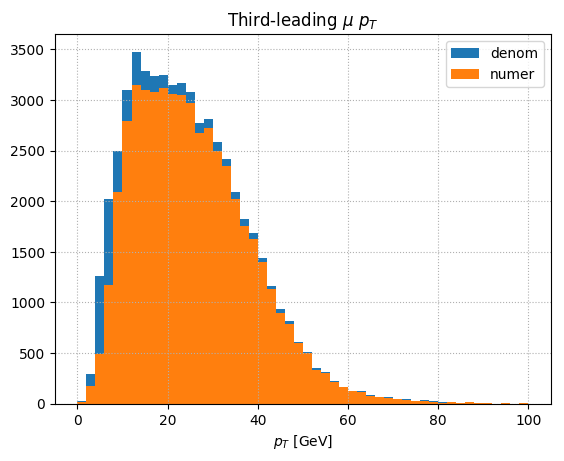

In [11]:
t = trees[1]
pt = t.array('pt')
start = pt.starts
denom = pt.content[start+2]
fd = t.array('fired')
numer = pt.content[start[fd]+2]
fig,ax = plt.subplots()
ax.hist(denom, bins=50, range=(0,100), label='denom')
ax.hist(numer, bins=50, range=(0,100), label='numer')
ax.legend(loc='best')
ax.set_title('Third-leading $\mu$ $p_{T}$')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.grid()

### Trigger `HLT_TrkMu16_DoubleTrkMu6NoFiltersNoVtx_v10` Efficiency as a function of third leading $\mu$ $p_{T}$

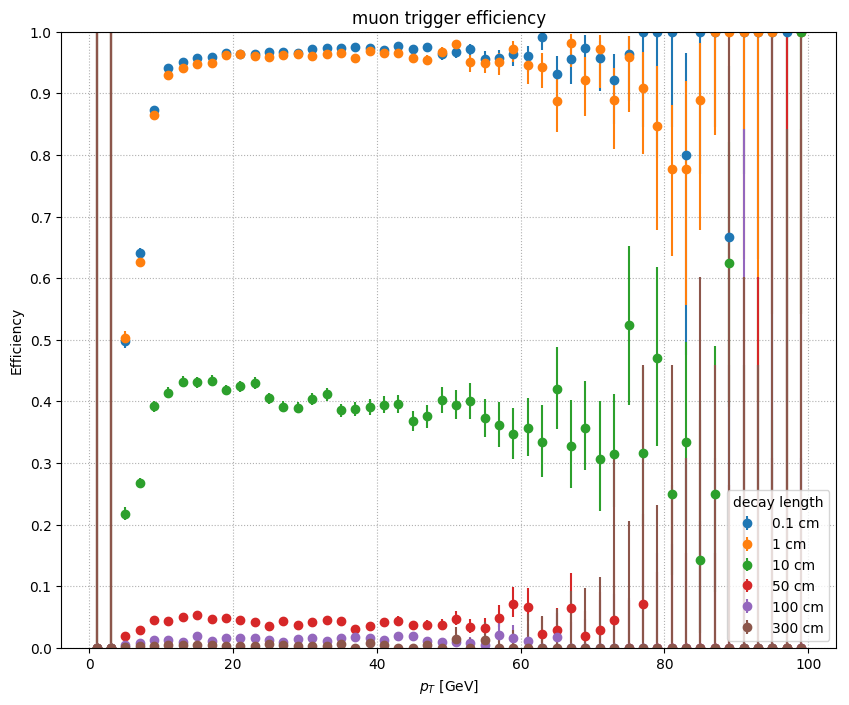

In [21]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in trees.items():
    d = t.array('pt')
    start = d.starts
    denom = d.content[start+2]
    fd = t.array('fired')
    numer = d.content[start[fd]+2]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

### Trigger `HLT_TrkMu16_DoubleTrkMu6NoFiltersNoVtx_v10` Efficiency as a function of third leading $\mu$ $\eta$

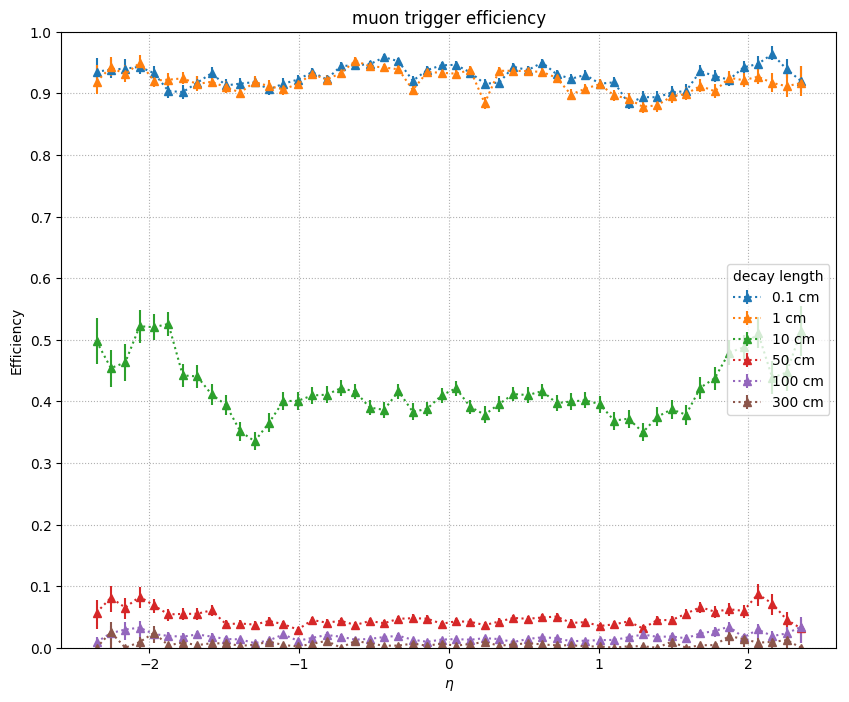

In [14]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in trees.items():
    d = t.array('eta')
    start = d.starts
    denom = d.content[start+2]
    fd = t.array('fired')
    numer = d.content[start[fd]+2]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, -2.4, 2.4)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, -2.4, 2.4)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

### trigger efficiency itself

In [15]:
trees = OrderedDict({
    0.1 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-1p20e-03_100k.root')['TRIGself_dsa/trigSelfEffiForMuTrack'],
      1 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-0p012_100k.root'   )['TRIGself_dsa/trigSelfEffiForMuTrack'],
     10 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-0p12_100k.root'    )['TRIGself_dsa/trigSelfEffiForMuTrack'],
     50 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-0p6_100k.root'     )['TRIGself_dsa/trigSelfEffiForMuTrack'],
    100 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-1p2_100k.root'     )['TRIGself_dsa/trigSelfEffiForMuTrack'],
    300 : uproot.open('../Firefighter/washAOD/test/2017/SIDMmumu_Mps-200_MZp-1p2_ctau-3p6_100k.root'     )['TRIGself_dsa/trigSelfEffiForMuTrack']     
})

0.1      0.925887
1.0      0.917454
10.0     0.393327
50.0     0.043403
100.0    0.013889
300.0    0.003499
dtype: float64


Info in <TBinomialEfficiencyFitter::result>:  chi2 6017.861352 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 5699.952408 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 628.516344 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 54.290786 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 39.148822 ndf 0 
Info in <TBinomialEfficiencyFitter::result>:  chi2 26.845775 ndf 0 


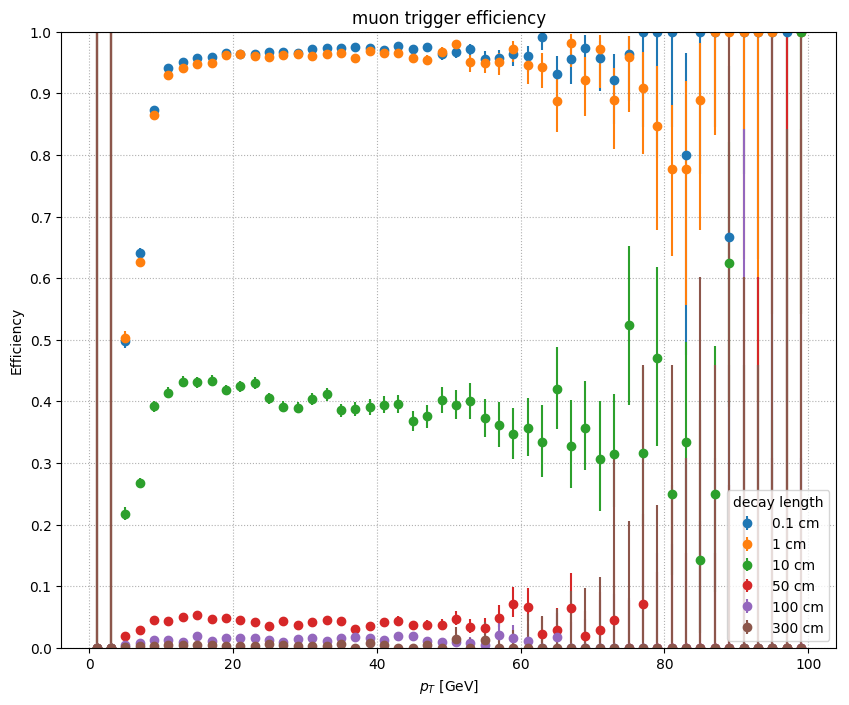

In [22]:
fig,ax = plt.subplots(figsize=(10,8))

fitResult = {}
for k, t in trees.items():
    d = t.array('pt')
    start = d.starts
    denom = d.content[start+2]
    fd = t.array('fired')
    numer = d.content[start[fd]+2]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)
    fitResult[k] = extract_fitParam_from_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='o', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$p_{T}$ [GeV]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

print(pd.Series({k: fitResult[k][-1] for k in fitResult})) # not very accurate, need adjust initial parameters for each turn-on curve

{'x': array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25.,
       27., 29., 31., 33., 35., 37., 39., 41., 43., 45., 47., 49., 51.,
       53., 55., 57., 59., 61., 63., 65., 67., 69., 71., 73., 75., 77.,
       79., 81., 83., 85., 87., 89., 91., 93., 95., 97., 99.]), 'y': array([0.        , 0.        , 0.00116347, 0.00272572, 0.00346955,
       0.0042735 , 0.00367816, 0.00454087, 0.00392597, 0.002414  ,
       0.00200669, 0.00204221, 0.00550314, 0.00400641, 0.00274474,
       0.00211864, 0.00324675, 0.0065445 , 0.        , 0.00686106,
       0.00441501, 0.        , 0.        , 0.004     , 0.        ,
       0.01481481, 0.        , 0.01282051, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 'yerr': array([[1.00000000e+00, 1.000

Warning in <TROOT::Append>: Replacing existing TH1: h0_300 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h1_300 (Potential memory leak).
Info in <TBinomialEfficiencyFitter::result>:  chi2 26.845775 ndf 0 


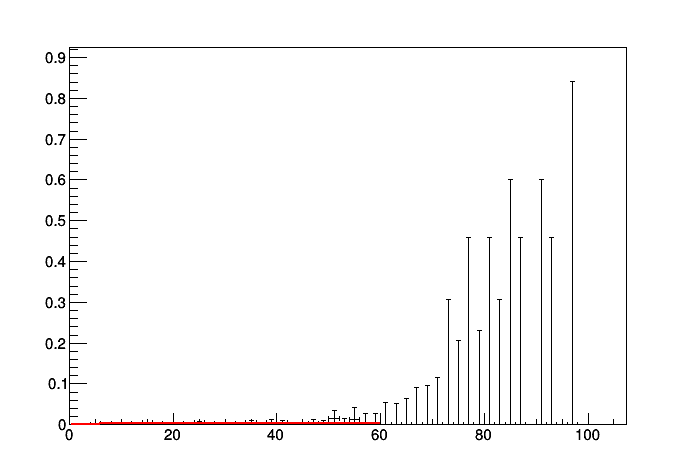

In [19]:
c = ROOT.TCanvas()

t = trees[300]
d = t.array('pt')
start = d.starts
denom = d.content[start+2]
fd = t.array('fired')
numer = d.content[start[fd]+2]
    
h0 = ROOT.TH1F(f'h0_{k}', '', 50, 0, 100)
h1 = ROOT.TH1F(f'h1_{k}', '', 50, 0, 100)
for x in np.nditer(denom): h0.Fill(x)
for x in np.nditer(numer): h1.Fill(x)
        
eff = ROOT.TEfficiency(h1, h0)

print(extract_teffi(eff))

eff.Draw()

# myfit = ROOT.TF1('myfit_', '[2]/(1+exp(-[0]*(x-[1]))) + [3]', 0, 60)
myfit = ROOT.TF1('myfit_', '[2]/(1+exp(-[0]*(x-[1])))', 0, 60)

myfit.SetParameters(0.02, 5, 0.005)
eff.Fit(myfit)

c.Draw()

for i in range(3):
    print(i, '%.6f'%myfit.GetParameter(i))
# print(myfit.GetParameter(2)+ myfit.GetParameter(3))

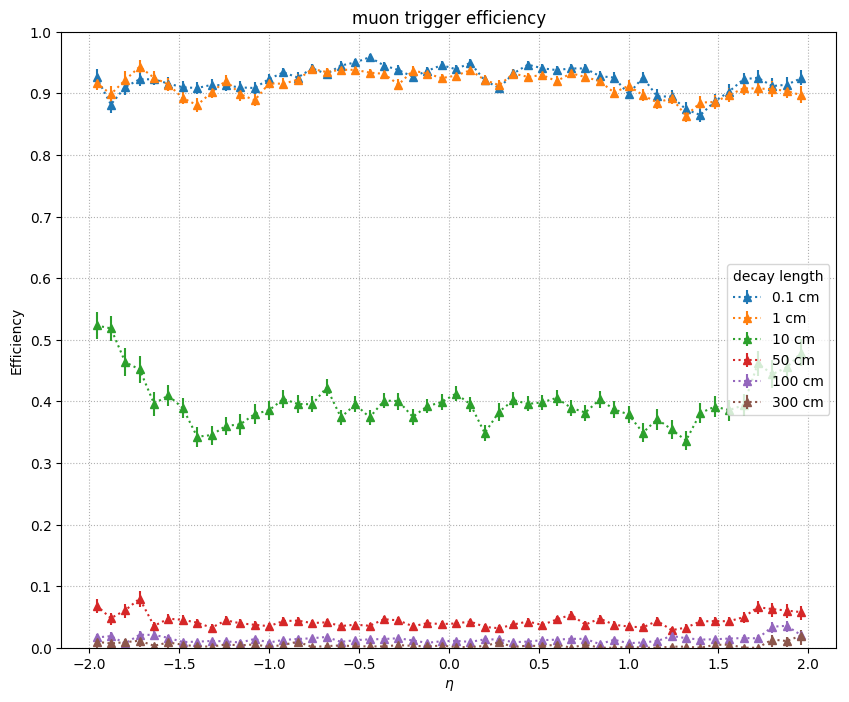

In [17]:
fig,ax = plt.subplots(figsize=(10,8))

for k, t in trees.items():
    d = t.array('eta')
    start = d.starts
    denom = d.content[start+2]
    fd = t.array('fired')
    numer = d.content[start[fd]+2]
    
    h0 = ROOT.TH1F(f'h0_{k}', '', 50, -2.0, 2.0)
    h1 = ROOT.TH1F(f'h1_{k}', '', 50, -2.0, 2.0)
    for x in np.nditer(denom): h0.Fill(x)
    for x in np.nditer(numer): h1.Fill(x)
        
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    ax.errorbar(x=data['x'], y=data['y'], yerr=data['yerr'], fmt='^:', label=f'{k} cm')
    
ax.set_title('muon trigger efficiency')
ax.set_xlabel('$\eta$')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.legend(loc='best', title='decay length')
ax.grid()

### Trigger efficiency as a function of dark photon's decay length

,0.1,1.0,10.0,50.0,100.0,300.0
HLT_TrkMu16_DoubleTrkMu6NoFiltersNoVtx,0.968306,0.960976,0.409801,0.043403,0.013889,0.003499


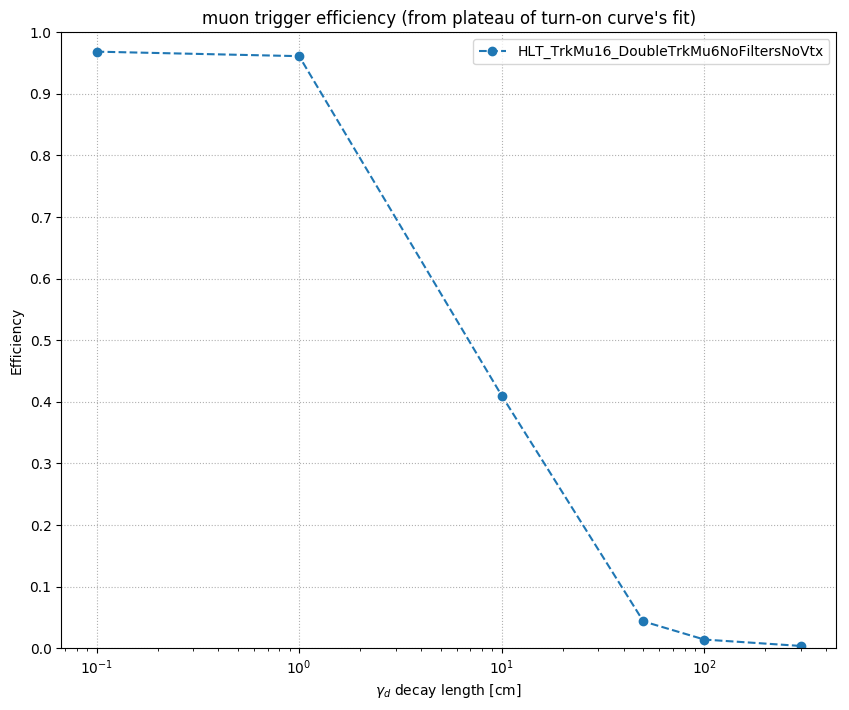

In [18]:
dl = np.array([0.1, 1.0, 10., 50., 100., 300.])
eff = {
    'HLT_TrkMu16_DoubleTrkMu6NoFiltersNoVtx': np.array([0.968306, 0.960976, 0.409801, 0.043403, 0.013889, 0.003499])
}

fig, ax = plt.subplots(figsize=(10,8))

for l, v in eff.items():
    ax.semilogx(dl, v, 'o--', label=l)
ax.legend(loc='best')
ax.set_title("muon trigger efficiency (from plateau of turn-on curve's fit)")
ax.set_xlabel('$\gamma_{d}$ decay length [cm]')
ax.set_ylabel('Efficiency')
ax.yaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_ylim((0,1))
ax.grid()

pd.DataFrame(data=eff, index=dl).T